## Zigbang 원룸 매물 데이터 수집

In [3]:
import requests
import pandas as pd

#### Process
    - 동이름으로 위도 경도 구하기
    - 위도 경도로 geohash 알아내기
    - geohash로 매물 아이디 가져오기
    - 매물 아이디로 매물 정보 가져오기

### 1\. 동이름으로 위도 경도 구하기

In [6]:
addr = '망원동'
url = f'https://apis.zigbang.com/v2/search?leaseYn=N&q={addr}&serviceType=원룸'
response = requests.get(url)
response
# url encode => https://meyerweb.com/eric/tools/dencoder/

<Response [200]>

In [8]:
response.text

'{"success":true,"code":"200","items":[{"id":4002,"type":"address","name":"망원동","hint":"","description":"서울특별시 마포구 망원동","lat":37.556785583496094,"lng":126.9013442993164,"zoom":5,"polygon":[],"_score":null,"_source":{"name_length":3,"local1":"서울시","local2":"마포구","local3":"망원동","web_level":15,"web_lat":37.556785583496094,"web_lng":126.9013442993164,"app_level":15,"app_lat":37.556785583496094,"app_lng":126.9013442993164,"법정동코드":"1144012300"},"zoom_level":{"google":15,"daum":4},"zoom_level_v2":{"app":5,"web":4}}],"next":null,"limit":0}'

In [12]:
data = response.json()['items'][0]
lat, lng = data['lat'], data['lng']
lat, lng

(37.556785583496094, 126.9013442993164)

### 2\. 위도 경도로 geohash 알아내기

In [13]:
# install geohash2
!pip install geohash2

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for geohash2: filename=geohash2-1.1-py3-none-any.whl size=15554 sha256=a96755d1c892b3bd38fde0368cd2ed4fce525378f651afeb20f99ee65c2bb30a
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\f6\7c\c4\1b3c6fea0ebc53bf730dc86bbee7a713d501455dfb4c1f0623
Successfully built geohash2


In [14]:
import geohash2

In [15]:
geohash = geohash2.encode(lat, lng, precision = 5)
geohash

'wydjx'

### 3\. geohash로 매물 아이디 가져오기

In [16]:
url = f'https://apis.zigbang.com/v2/items/oneroom\
?geohash={geohash}&depositMin=0&rentMin=0&salesTypes[0]=전세&salesTypes[1]=월세\
&domain=zigbang&checkAnyItemWithoutFilter=true'
response = requests.get(url)
response

<Response [200]>

In [18]:
response.text[:500]

'{"items":[{"lat":37.52908310912002,"lng":126.90043005188342,"itemId":39817840,"itemBmType":"ZIGBANG"},{"lat":37.5290931999848,"lng":126.90041540016226,"itemId":40042434,"itemBmType":"ZIGBANG"},{"lat":37.52958812411199,"lng":126.90043722986579,"itemId":40058332,"itemBmType":"ZIGBANG"},{"lat":37.5290708547459,"lng":126.89894442162696,"itemId":39791961,"itemBmType":"ZIGBANG"},{"lat":37.529588188827304,"lng":126.89956021538748,"itemId":40096518,"itemBmType":"ZIGBANG"},{"lat":37.529159969749784,"lng"'

In [20]:
items = response.json()['items']
items = [item['itemId'] for item in items]
len(items), items[:5]

(604, [39817840, 40042434, 40058332, 39791961, 40096518])

### 4\. 매물 아이디로 매물 정보 가져오기

In [25]:
url = 'https://apis.zigbang.com/v2/items/list'
params = {
    'domain':'zigbang',
    'item_ids' : items,
}

response = requests.post(url, params)
response

<Response [200]>

In [30]:
pd.options.display.max_columns = 40
pd.options.display.max_columns

40

In [33]:
df.columns

Index(['item_id', 'section_type', 'images_thumbnail', 'sales_type',
       'sales_title', 'deposit', 'rent', 'size_m2', '공급면적', '전용면적', '계약면적',
       'room_type_title', 'floor', 'floor_string', 'building_floor', 'title',
       'is_first_movein', 'room_type', 'status', 'tags', 'service_type',
       'random_location', 'manage_cost', 'reg_date', 'is_new', 'addressOrigin',
       'action', 'contract', 'address', 'is_zzim', 'address1', 'address2',
       'address3', 'item_bm_type', 'zikim'],
      dtype='object')

In [35]:
data = response.json()['items']
columns = ['item_id', 'sales_title', 'deposit', 'rent',  'size_m2', 'title', 'address1']
df = pd.DataFrame(data)[columns]
df = df[df['address1'].str.contains('망원동')].reset_index(drop = True)
df.tail()

,item_id,sales_title,deposit,rent,size_m2,title,address1
58,39591216,전세,45000,0,99.20,"햇빛 가득한 깔끔한 쓰리룸, 즉시 입주 가능",서울시 마포구 망원동
59,39677924,월세,41000,10,68.68,구청역세권 망원초근처 채광굿 방3 화2 베란다,서울시 마포구 망원동
60,40099714,전세,43000,0,68.68,구청역세권 망원초근처 채광굿 방3 화2 베란다,서울시 마포구 망원동
61,40009046,월세,500,50,13.22,신축급풀옵션마포구청역5분깔끔한방,서울시 마포구 망원동
62,40089526,월세,200,63,16.53,신축급 깔끔원룸,서울시 마포구 망원동


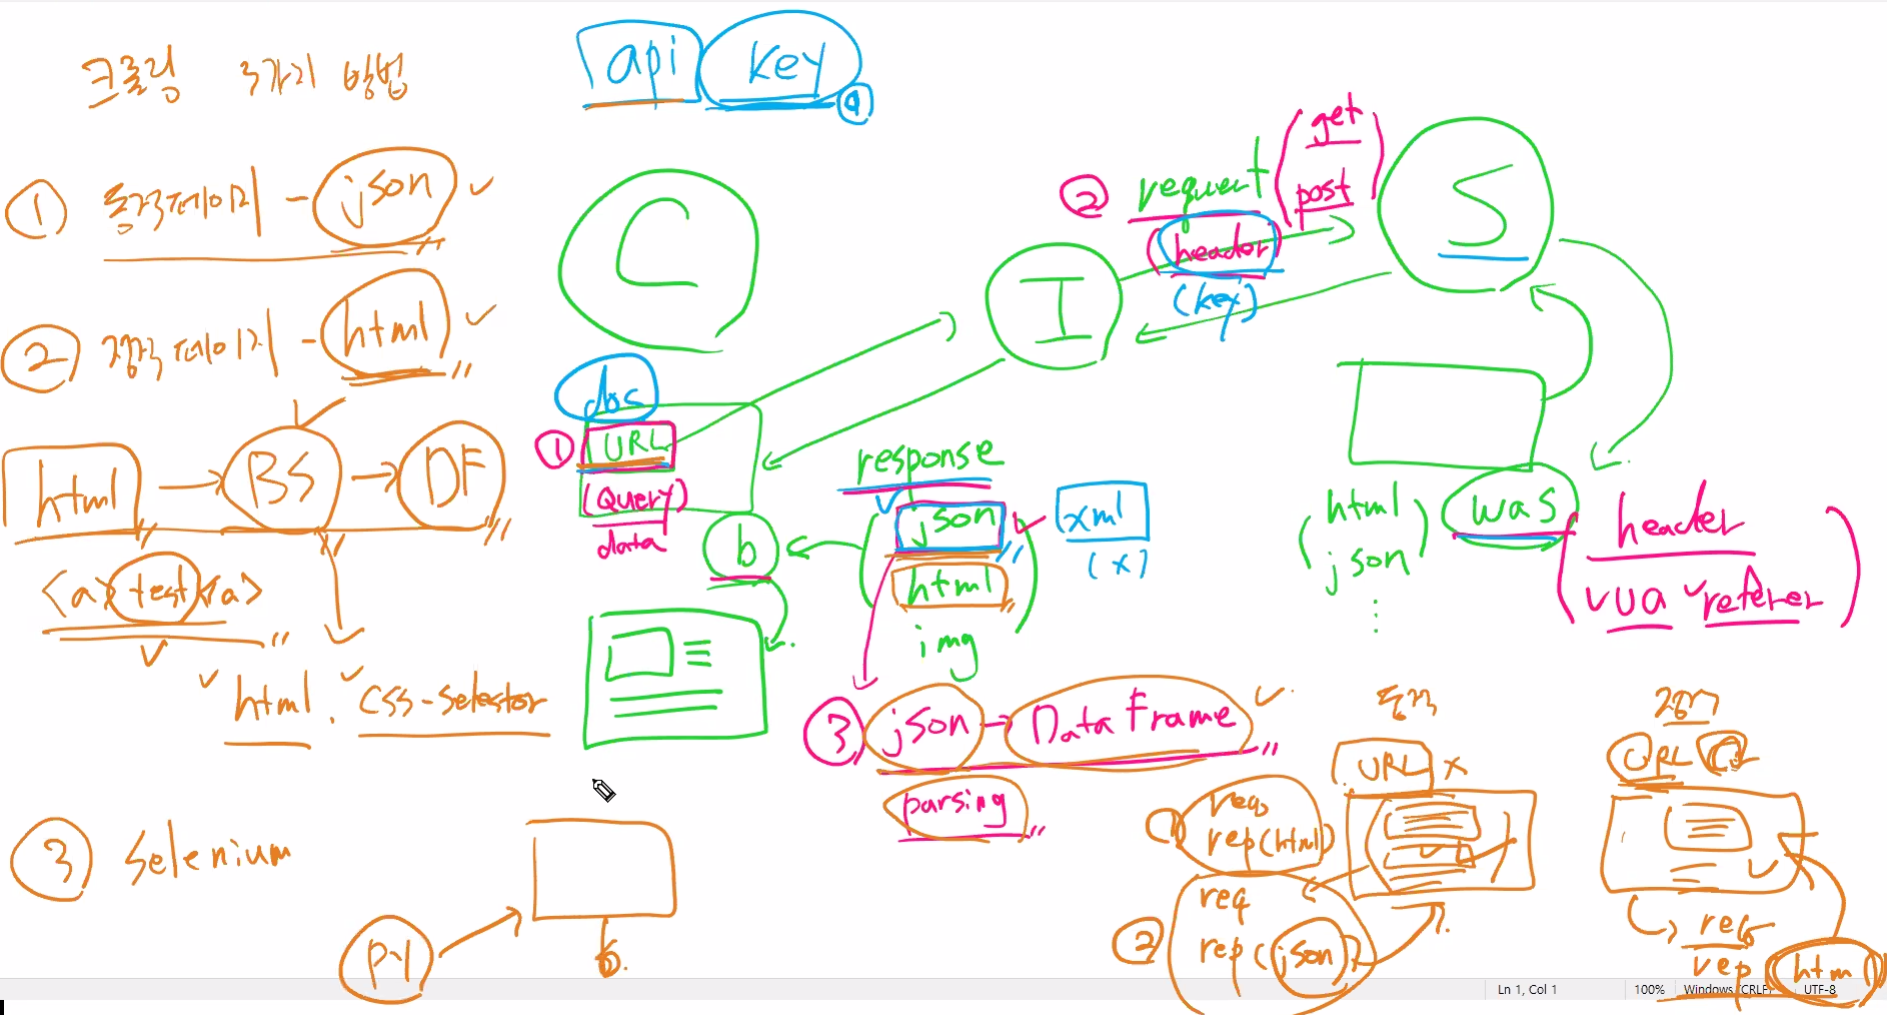